# Overview

Here we are simply trying to minimize the root mean square error for predicting the 50th percentile [O/H] from SDSS spectroscopy. Everything in this notebook follows from the previous one.

# Imports and other necessary functions

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import torch 

from IPython.display import display


In [2]:
PATH = os.path.abspath('..')

In [3]:
def parse_csv_multi_class_values(path_to_csv):
    """Parse filenames and values for classes from a CSV file.

    This method expects that the csv file at path :fn: has one column for filenames,
    while all the other columns represent classes.
    Expects a header with class names

    Arguments:
        path_to_csv: Path to a CSV file.

    Returns:
        a three-tuple of:            
            a list of filenames
            a list of values in the same order
            a dictionary of classes by classIndex           
    """
    with open(path_to_csv) as fileobj:
        reader = csv.reader(fileobj)
        header = next(reader)
        csv_lines = [l for l in reader]

    fnames = [fname for fname, *_ in csv_lines]
    classes = header[1:]
    values = [vals for _, *vals in csv_lines]
    idx2class = {i:c for i, c in enumerate(classes)}
   
    return fnames, values, idx2class

def csv_source_multi_class(folder, csv_file, suffix=''):
    fnames, values, idx2class = parse_csv_multi_class_values(csv_file)
    full_names = [os.path.join(folder,fn+suffix) for fn in fnames]
   
    val_arr = np.array(values).astype(np.float32)
    
    return full_names, val_arr, idx2class

@classmethod
def from_multiclass_csv(cls, path, folder, csv_fname, bs=64, tfms=(None,None),
           val_idxs=None, suffix='', test_name=None, num_workers=8):
    """ Read in images and their labels given as a CSV file.
--
    This method should be used when training image labels are given in an CSV file as opposed to
    sub-directories with label names.

    Arguments:
        path: a root path of the data (used for storing trained models, precomputed values, etc)
        folder: a name of the folder in which training images are contained.
        csv_fname: a name of the CSV file which contains target labels.
        bs: batch size
        tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
        val_idxs: index of images to be used for validation. e.g. output of `get_cv_idxs`.
            If None, default arguments to get_cv_idxs are used.
        suffix: suffix to add to image names in CSV file (sometimes CSV only contains the file name without file
                extension e.g. '.jpg' - in which case, you can set suffix as '.jpg')
        test_name: a name of the folder which contains test images.
        skip_header: skip the first row of the CSV file.
        num_workers: number of workers

    Returns:
        ImageClassifierData
    """
    fnames,y,idx2class = csv_source_multi_class(folder, csv_fname, suffix)

    val_idxs = get_cv_idxs(len(fnames)) if val_idxs is None else val_idxs
    ((val_fnames,trn_fnames),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), y)

    test_fnames = read_dir(path, test_name) if test_name else None
    
    f = FilesIndexArrayRegressionDataset
    datasets = cls.get_ds(f, (trn_fnames,trn_y), (val_fnames,val_y), tfms,
                           path=path, test=test_fnames)
    return cls(path, datasets, bs, num_workers, classes=list(idx2class.values()))

ImageClassifierData.from_multiclass_csv = from_multiclass_csv

# Initialize network

Let's try to see how well we can do with resnet34

In [4]:
train_label_csv = f'{PATH}/catalogs/train-metaldist.csv'
df = pd.read_csv(train_label_csv, index_col=0)

n = len(df)

# test-val split
val_idxs = get_cv_idxs(n)

In [41]:
sz = 64
bs = 512
arch = resnet34

def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    return ImageClassifierData.from_multiclass_csv(PATH, 'images', train_label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=8)

In [42]:
data = get_data(sz, bs)
learn = ConvLearner.pretrained(arch, data)

In [43]:
def rmse(x, y):
    return torch.sqrt(F.mse_loss(x,y))

metrics = [rmse]
learn.crit = rmse

 87%|████████▋ | 1047/1200 [00:58<00:08, 17.92it/s, loss=2.41] 

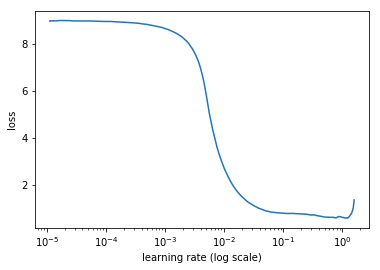

In [44]:
learn.lr_find()
learn.sched.plot()

# Begin training

## Start with size 64x64 and batch size of 512

Here we will try defining specific learning rate phases, as described by [Sylvain Gugger](https://github.com/fastai/fastai/blob/master/courses/dl2/training_phase.ipynb)

In [45]:
lr = 0.5
phases = [TrainingPhase(epochs=1, opt_fn=optim.SGD, lr=(lr/5, lr), lr_decay=DecayType.LINEAR, 
                          momentum=(0.95,0.5), momentum_decay=DecayType.LINEAR),
           TrainingPhase(epochs=1, opt_fn=optim.SGD, lr=(lr, lr/5), lr_decay=DecayType.LINEAR, 
                          momentum=(0.85,0.5), momentum_decay=DecayType.LINEAR)]

In [46]:
learn.fit_opt_sched(phases)

epoch      trn_loss   val_loss                                 
    0      0.154596   0.150283  
    1      0.151278   0.142803                                 


[array([0.1428])]

In [47]:
lr = 0.1
learn.fit(lr, n_cycle=1, cycle_len=3)

epoch      trn_loss   val_loss                                 
    0      0.148407   0.141123  
    1      0.147047   0.141048                                 
    2      0.146943   0.140885                                 


[array([0.14088])]

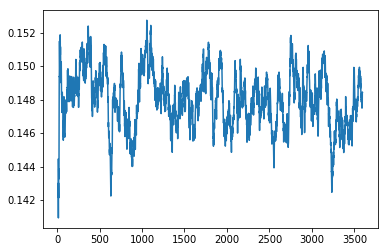

In [48]:
learn.sched.plot_loss()

In [37]:
learn.save('resnet34-sz64-bs512_init')

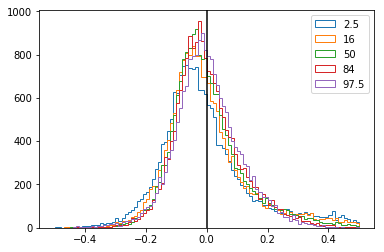

In [38]:
p_val, y_val = learn.TTA()

for i in range(5):
    plt.hist(np.mean(p_val, axis=0)[:, i]-y_val[:, i], bins=100, histtype='step', range=[-0.5, 0.5]);
plt.legend(['2.5', '16', '50', '84', '97.5']);
plt.axvline(0, c='k');


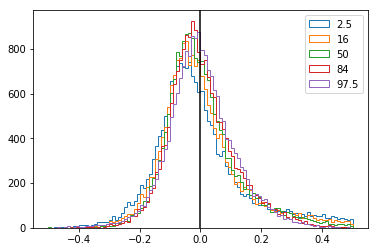

In [39]:

for i in range(5):
    plt.hist(np.median(p_val, axis=0)[:, i]-y_val[:, i], bins=100, histtype='step', range=[-0.5, 0.5]);
plt.legend(['2.5', '16', '50', '84', '97.5']);
plt.axvline(0, c='k');

In [40]:
np.sqrt(np.mean((np.mean(p_val, axis=0) - y_val)**2, axis=0))

array([0.17492, 0.14817, 0.12485, 0.11181, 0.11065], dtype=float32)

In [49]:
lr = 0.03
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                 
    0      0.147388   0.141613  
    1      0.147981   0.141064                                 
    2      0.146433   0.141179                                 
    3      0.145452   0.141123                                 
    4      0.143438   0.141323                                 
    5      0.14399    0.140834                                 
    6      0.14637    0.140701                                 


[array([0.1407])]

Histograms show that network is seriously underfitting; predictions are consistently too low for predicting [O/H].

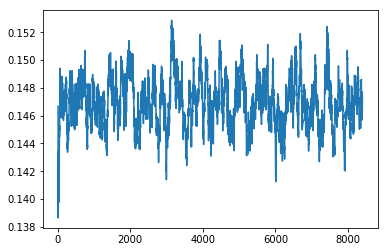

In [50]:
learn.sched.plot_loss()

In [43]:
learn.save('resnet34-sz64-bs512_init-2')

## Unfreeze early layers

### Begin differential learning with lr=0.1

In [51]:
learn.unfreeze()
lrs = 0.1 * np.array([1/9, 1/3, 1])

learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                 
    0      0.107839   0.101522  
    1      0.110883   0.098193                                 
    2      0.104732   0.097599                                 
    3      0.113828   0.100882                                 
    4      0.106136   0.096468                                 
    5      0.100291   0.09521                                   
    6      0.099489   0.094891                                  


[array([0.09489])]

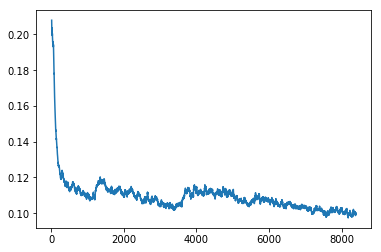

In [52]:
learn.sched.plot_loss()

In [53]:
#learn.save('resnet34-sz64-bs512_diff-1')
#learn.load('resnet34-sz64-bs512_diff-1')

### Continue training with annealed learning rate

In [55]:
lrs = 1e-2 * np.array([1/9, 1/3, 1])
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                  
    0      0.099936   0.095374  
    1      0.098846   0.095005                                  
    2      0.101357   0.094872                                  
    3      0.099665   0.095473                                  
    4      0.100165   0.094679                                  
    5      0.100214   0.094226                                  
    6      0.096078   0.094821                                  


[array([0.09482])]

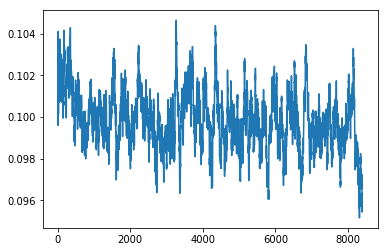

In [56]:
learn.sched.plot_loss()

In [59]:
#learn.save('resnet34-sz64-bs512_diff-2')
learn.load('resnet34-sz64-bs512_diff-2')

These last few cycles didn't seem to do much...

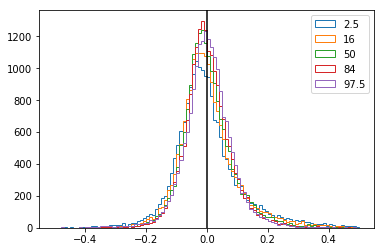

In [60]:
p_val, y_val = learn.TTA()

for i in range(5):
    plt.hist(np.mean(p_val, axis=0)[:, i]-y_val[:, i], bins=100, histtype='step', range=[-0.5, 0.5]);
plt.legend(['2.5', '16', '50', '84', '97.5']);
plt.axvline(0, c='k');

## Size up to 128x128
Let's re-freeze + train some

In [61]:
data = get_data(128, 512)
learn.set_data(data)

epoch      trn_loss   val_loss                                 
    0      0.132472   0.124173  
    1      0.126877   0.119261                                 
    2      0.124655   0.11543                                  


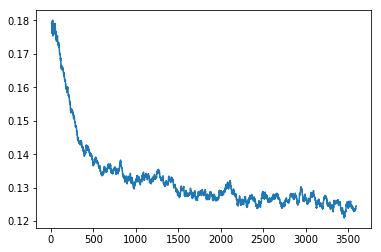

In [62]:
learn.freeze()

lr = 1e-2
learn.fit(lr, 3, cycle_len=1)
learn.sched.plot_loss()

In [63]:
learn.save('resnet34-sz64,128-bs512_frozen-1')

Unfreeze and train more

epoch      trn_loss   val_loss                                 
    0      0.108044   0.10283   
    1      0.106297   0.097042                                 
    2      0.102579   0.097369                                  
    3      0.103262   0.098681                                 
    4      0.103274   0.095393                                  
    5      0.100604   0.094684                                  
    6      0.1015     0.095193                                  


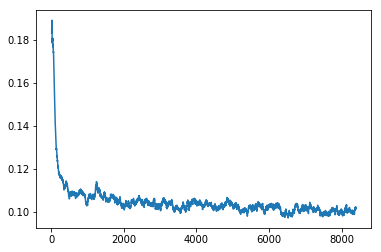

In [64]:
learn.unfreeze()

lrs = 1e-2 * np.array([1/9, 1/3, 1])

learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

In [65]:
learn.save('resnet34-sz64,128-bs512_diff-1')

epoch      trn_loss   val_loss                                  
    0      0.100207   0.094533  
    1      0.100587   0.09444                                   
    2      0.098645   0.095061                                  
    3      0.101365   0.095811                                  
    4      0.098415   0.095604                                  
    5      0.099888   0.094645                                  
    6      0.099178   0.094789                                  
    7      0.096952   0.094295                                  
    8      0.099052   0.093759                                  
    9      0.098993   0.093654                                  
    10     0.098899   0.093469                                  
    11     0.098786   0.093857                                  
    12     0.098076   0.09372                                   
    13     0.098158   0.094088                                  
    14     0.097354   0.09411                            

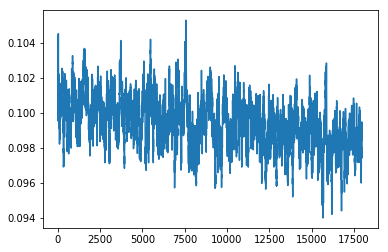

In [66]:
lrs = 3e-3 * np.array([1/9, 1/3, 1])

learn.fit(lrs, 4, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

In [67]:
#learn.save('resnet34-sz64,128-bs512_diff-2')
#learn.load('resnet34-sz64,128-bs512_diff-2')

### Anneal more?

epoch      trn_loss   val_loss                                  
    0      0.098402   0.09332   
    1      0.098561   0.093355                                  
    2      0.099319   0.094776                                  
    3      0.102459   0.09366                                   
    4      0.098091   0.093522                                  
    5      0.097608   0.093498                                  
    6      0.09903    0.095245                                  
    7      0.10018    0.093411                                  
    8      0.098979   0.094053                                  
    9      0.096716   0.093491                                  
    10     0.09718    0.093535                                  
    11     0.098176   0.093697                                  
    12     0.096451   0.093547                                  
    13     0.098379   0.093586                                  
    14     0.098757   0.093738                           

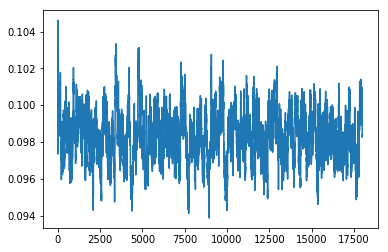

In [68]:
lrs = 3e-4 * np.array([1/9, 1/3, 1])

learn.fit(lrs, 4, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

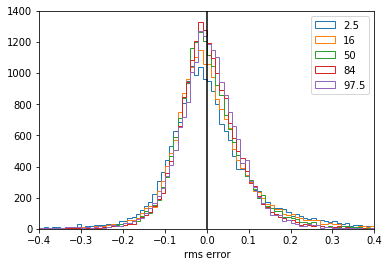

In [69]:
p_val, y_val = learn.TTA()

for i in range(5):
    plt.hist(np.mean(p_val, axis=0)[:, i]-y_val[:, i], bins=100, histtype='step', range=[-0.5, 0.5]);
plt.legend(['2.5', '16', '50', '84', '97.5']);
plt.xlim(-0.4, 0.4)
plt.axvline(0, c='k')
plt.xlabel('rms error');

In [72]:
pred_val = np.mean(p_val, axis=0)

np.sqrt(np.mean((pred_val - y_val)**2, axis=0))

array([0.11864, 0.10001, 0.08479, 0.07782, 0.0796 ], dtype=float32)

# Further improvements
- Decrease dropout?
Here I would be trying to decrease the dropout probability in order to get closer to overfit
- Lower batch size? 
This is a test to lower batch size and thus make gradients *more* noisy. In doing so I hope that the loss can hop out of local minima.


## Decreasing dropout rate (0.25, 0.5) -> (0.025, 0.1)

In [84]:
learn.model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [85]:
learn.model[11].p = 0.025
learn.model[15].p = 0.1

epoch      trn_loss   val_loss                                  
    0      0.099868   0.094008  
    2      0.097717   0.09411                                   
    3      0.098205   0.093627                                  
    4      0.097412   0.093225                                  
    5      0.094692   0.093693                                  
    6      0.096084   0.09286                                   


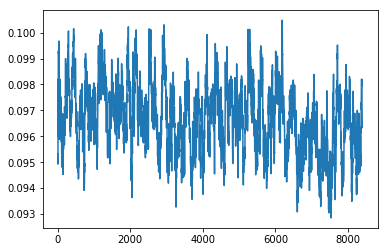

In [87]:
lrs = 3e-3 * np.array([1/9, 1/3, 1])

learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

Interesting. Still no huge difference from before, although the val loss is still slightly shrinking...

In [88]:
p_val, y_val = learn.TTA()
pred_val = np.mean(p_val, axis=0)

rms_errors = np.sqrt(np.mean((pred_val - y_val)**2, axis=0))

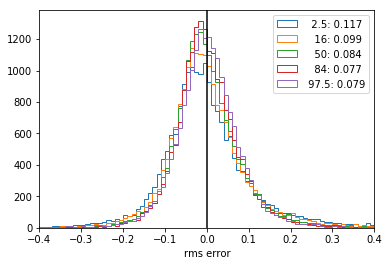

In [94]:
for i in range(5):
    plt.hist(pred_val[:, i]-y_val[:, i], bins=100, histtype='step', range=[-0.5, 0.5]);
plt.legend([f'{percentile:>5s}: {error:.3f}' for percentile, error in zip(['2.5', '16', '50', '84', '97.5'], rms_errors)]);
plt.xlim(-0.4, 0.4)
plt.axvline(0, c='k')
plt.xlabel('rms error');

In [95]:
learn.save('resnet34-sz64,128-bs512_decreased-dropout')

## Decrease batch size from 512 to 64

In [98]:
data = get_data(128, 64)
learn.set_data(data)

epoch      trn_loss   val_loss                                  
    0      0.09645    0.093303  
    1      0.096866   0.093167                                  
    2      0.097104   0.093278                                  


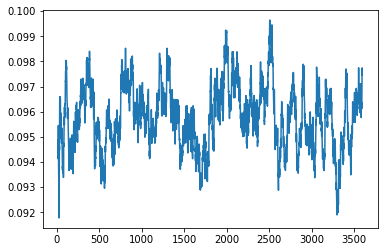

In [99]:
lrs = 3e-3 * np.array([1/9, 1/3, 1])

learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

In [100]:
learn.save('resnet34-sz64,128-bs512,64_decreased_dropout')

## Train for a while...

In [ ]:
lrs = 1e-3 * np.array([1/9, 1/3, 1])

learn.fit(lrs, 8, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

 40%|████      | 480/1200 [00:32<00:48, 14.73it/s, loss=0.096] 

In [ ]:
p_val, y_val = learn.TTA()
pred_val = np.mean(p_val, axis=0)

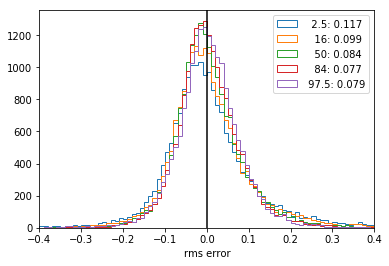

In [105]:
rms_errors = np.sqrt(np.mean((pred_val - y_val)**2, axis=0))

for i in range(5):
    plt.hist(pred_val[:, i]-y_val[:, i], bins=100, histtype='step', range=[-0.5, 0.5]);
plt.legend([f'{percentile:>5s}: {error:.3f}' for percentile, error in zip(['2.5', '16', '50', '84', '97.5'], rms_errors)]);
plt.xlim(-0.4, 0.4)
plt.axvline(0, c='k')
plt.xlabel('rms error');

In [106]:
#learn.save('resnet34-sz64,128-bs512,64_decreased_dropout-2')
learn.load('resnet34-sz64,128-bs512,64_decreased_dropout-2')

In [107]:
lrs = 1e-4 * np.array([1/9, 1/3, 1])

learn.fit(lrs, 1, cycle_len=1)

epoch      trn_loss   val_loss                                  
    0      0.098037   0.093033  


[array([0.09303])]

In [108]:
lrs = 1e-3 * np.array([1e-2, 1e-1, 1])
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                  
    0      0.095991   0.092963  
    1      0.096358   0.092958                                  
    2      0.095169   0.093441                                  
    3      0.095134   0.093634                                  
    4      0.094907   0.093647                                  
    5      0.096768   0.093021                                  
    6      0.096992   0.092954                                  


[array([0.09295])]

In [109]:
learn.freeze()

In [110]:
learn.fit(3e-4, 2, cycle_len=1, cycle_mult=1)

epoch      trn_loss   val_loss                                  
    0      0.094541   0.092936  
    1      0.096679   0.092914                                  


[array([0.09291])]